In [41]:
%matplotlib inline
import numpy as np
import pandas as pd
import pywt
import seaborn as sns
import scaleogram as scg 
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
from mat4py import loadmat
from scipy.fftpack import fft
import wfdb
import re
from math import *
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#from tqdm import tqdm
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
sample_size=5000

# Read source for create a dataset of annotations
Source : https://physionet.org/content/butqdb/1.0.0/

In [5]:
# Create concatenated dataset with annotation & added informations for all patients
# source wfdb
header_list = ["start1", "end1", "class1","start2", "end2", "class2","start3", "end3", "class3","start", "end", "class"]
record_list = wfdb.get_record_list('butqdb') # Save the list of ECG file names
dataannall = pd.DataFrame(columns=header_list) 
for rcd in record_list:
    # Look for each patient the annotation file
    #print(rcd)
    if re.search(r'ECG$', rcd):
        record_name = f"../aura-data/{rcd}"
        print(record_name, end="\r")
        record_csv = f"../aura-data/{rcd.replace('ECG','ANN')}.csv"
        dataann = pd.read_csv(record_csv, names=header_list)
        dataannall = pd.concat([dataannall,dataann.assign(record=rcd.split('/')[0])], ignore_index=True)
#Add columns to dataset : record, signal length, number of samples of 5000 data, filter with not null value in label columns
dataannall['signal_length']=dataannall['end'] - dataannall['start'] 
dataannall["sample"]=round(dataannall["signal_length"]/sample_size)
dataset = dataannall[dataannall["class"].notnull() & dataannall["start"].notnull() & dataannall["end"].notnull() ]


In [6]:
dataset.shape

(7154, 15)

In [7]:
dataset.head()

start1       end1  class1   start2      end2  class2 start3   end3  \
0        1.0   198867.0     2.0      1.0   19525.0     1.0      1   7047   
1   198868.0   320282.0     1.0  19526.0   28694.0     2.0   7048  17209   
2   320283.0   373109.0     2.0  28695.0   32739.0     1.0  17210  28390   
3   373110.0  2197974.0     1.0  32740.0   96699.0     2.0  28391  32653   
4  2197975.0  2582746.0     2.0  96700.0  110564.0     1.0  32654  71061   

  class3    start       end  class  record  signal_length  sample  
0      2      1.0    7047.0    2.0  100001         7046.0     1.0  
1      1   7048.0   17209.0    1.0  100001        10161.0     2.0  
2      2  17210.0   28694.0    2.0  100001        11484.0     2.0  
3      1  28695.0   32653.0    1.0  100001         3958.0     1.0  
4      2  32654.0  112474.0    2.0  100001        79820.0    16.0

In [8]:
dataset.describe()

start1          end1       class1        start2          end2  \
count  2.076000e+03  2.076000e+03  2076.000000  4.305000e+03  4.305000e+03   
mean   5.735894e+07  5.817328e+07     1.748073  5.950179e+07  5.987307e+07   
std    3.225315e+07  3.202552e+07     0.731805  3.072217e+07  3.057915e+07   
min    1.000000e+00  1.988670e+05     0.000000  1.000000e+00  1.952500e+04   
25%    2.961164e+07  2.970962e+07     1.000000  3.180192e+07  3.216237e+07   
50%    5.676074e+07  5.760000e+07     2.000000  5.791413e+07  5.792801e+07   
75%    7.522529e+07  7.664065e+07     2.000000  7.722608e+07  7.766738e+07   
max    1.391201e+08  1.391470e+08     3.000000  1.391468e+08  1.391470e+08   

            class2         start           end        class  signal_length  \
count  4305.000000  7.154000e+03  7.154000e+03  7154.000000   7.154000e+03   
mean      1.572590  5.601431e+07  5.625521e+07     1.604417   2.409030e+05   
std       0.603114  2.802337e+07  2.796447e+07     0.609641   2.530322e+06   
min       0.000000  1.000000e+00  7.047000e+03     0.000000   3.020000e+02   
25%       1.000000  3.405290e+07  3.411941e+07     1.000000   2.264250e+03   
50%       2.000000  5.507225e+07  5.570303e+07     2.000000   5.853000e+03   
75%       2.000000  6.858724e+07  6.945778e+07     2.000000   1.982150e+04   
max       3.000000  1.391201e+08  1.391470e+08     3.000000   7.464800e+07   

             sample  
count   7154.000000  
mean      48.144255  
std      506.072488  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        4.000000  
max    14930.000000

In [9]:
dataset.sort_values(by=['signal_length']).head(10)

start1        end1  class1      start2        end2  class2  \
2164   29830121.0  29843829.0     2.0  29833497.0  29842799.0     2.0   
6902          NaN         NaN     NaN         NaN         NaN     NaN   
14215  57653762.0  57664665.0     1.0  29052794.0  29058124.0     1.0   
1961   29896114.0  29909814.0     1.0  29430978.0  29432026.0     2.0   
14982         NaN         NaN     NaN  65811759.0  65824014.0     3.0   
15543  57711177.0  57779132.0     1.0  29622202.0  29624040.0     1.0   
2087          NaN         NaN     NaN         NaN         NaN     NaN   
1347          NaN         NaN     NaN  29422321.0  29423807.0     2.0   
15582         NaN         NaN     NaN  57917191.0  57917810.0     2.0   
14943         NaN         NaN     NaN  65570247.0  65579982.0     1.0   

            start3         end3 class3       start         end  class  record  \
2164      29041071     29041373      2  29041071.0  29041373.0    2.0  104001   
6902      22772239     22806837      1  42187296.0  42187599.0    2.0  111001   
14215     28815944     28816279      1  28871845.0  28872149.0    1.0  121001   
1961      29201971     29203041      2  29367658.0  29367979.0    2.0  103003   
14982     58413007     58414129      1  65500416.0  65500737.0    2.0  124001   
15543     28902711     29014385      1  29637312.0  29637634.0    1.0  126001   
2087      29712177     29713943      2  29974330.0  29974654.0    2.0  103003   
1347   2.95904e+07  2.95909e+07      2  29583767.0  29584095.0    2.0  100002   
15582     57655491     57655835      2  58410626.0  58410956.0    2.0  126001   
14943     58189527     58190516      2  65289466.0  65289798.0    2.0  124001   

       signal_length  sample  
2164           302.0     0.0  
6902           303.0     0.0  
14215          304.0     0.0  
1961           321.0     0.0  
14982          321.0     0.0  
15543          322.0     0.0  
2087           324.0     0.0  
1347           328.0     0.0  
15582          330.0     0.0  
14943          332.0     0.0

In [10]:
dataannall.sort_values(by=['sample'],ascending=False).head(10)

start1        end1  class1      start2        end2  class2  \
14558         NaN         NaN     NaN         NaN         NaN     NaN   
14419         NaN         NaN     NaN         NaN         NaN     NaN   
2299          1.0  47323379.0     3.0         1.0  47323871.0     3.0   
15596         NaN         NaN     NaN  58407654.0  58408005.0     2.0   
13716  57600001.0  58800000.0     1.0  29389929.0  29392545.0     2.0   
14375         NaN         NaN     NaN         NaN         NaN     NaN   
13539         NaN         NaN     NaN         NaN         NaN     NaN   
14073         NaN         NaN     NaN  58800001.0  89091000.0     0.0   
13892         NaN         NaN     NaN         NaN         NaN     NaN   
1512          1.0  28800000.0     0.0         1.0  28800000.0     0.0   

         start3      end3 class3       start          end  class  record  \
14558  29981332  29991362      2  58800001.0  133448000.0    0.0  123001   
14419  58497423  58499060      1  58800001.0  122798000.0    0.0  122001   
2299          1  47323500      3         1.0   47323500.0    3.0  105001   
15596  57821475  57824016      2  58800001.0   92361000.0    0.0  126001   
13716  28903735  28905450      2  58800001.0   91651000.0    0.0  114001   
14375  58662590  58670947      1  58800001.0   91233000.0    0.0  121001   
13539  36544236  36546336      1  58800001.0   91148000.0    0.0  113001   
14073  58102368  58112099      2  58800001.0   89091000.0    0.0  118001   
13892  58398360  58401557      1  58800001.0   87934000.0    0.0  115001   
1512          1  28800000      0         1.0   28800000.0    0.0  103001   

       signal_length   sample  
14558     74647999.0  14930.0  
14419     63997999.0  12800.0  
2299      47323499.0   9465.0  
15596     33560999.0   6712.0  
13716     32850999.0   6570.0  
14375     32432999.0   6487.0  
13539     32347999.0   6470.0  
14073     30290999.0   6058.0  
13892     29133999.0   5827.0  
1512      28799999.0   5760.0

In [11]:
dataset.record.unique()

array(['100001', '100002', '103001', '103002', '103003', '104001',
       '105001', '111001', '113001', '114001', '115001', '118001',
       '121001', '122001', '123001', '124001', '125001', '126001'],
      dtype=object)

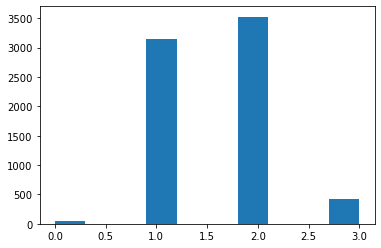

In [12]:
plt.hist(dataset['class'], bins=10);
plt.show()

In [13]:
fig = px.histogram(dataset, x="class", nbins=10)
fig.show()

In [14]:
fig = px.histogram(dataset, x="sample", nbins=10)
fig.show()

In [15]:
dataannall.dtypes

start1           float64
end1             float64
class1           float64
start2           float64
end2             float64
class2           float64
start3            object
end3              object
class3            object
start            float64
end              float64
class            float64
record            object
signal_length    float64
sample           float64
dtype: object

In [16]:
fig = px.histogram(dataannall[dataannall['sample'] < 10]['sample'], nbins=10)
fig.show()

In [17]:
pie_chart_data = dataset[dataset['record'] == '100001'].groupby('class')['sample'].sum()
pie_chart_data.shape

(3,)

In [18]:
dataannall.record.unique()

array(['100001', '100002', '103001', '103002', '103003', '104001',
       '105001', '111001', '113001', '114001', '115001', '118001',
       '121001', '122001', '123001', '124001', '125001', '126001'],
      dtype=object)

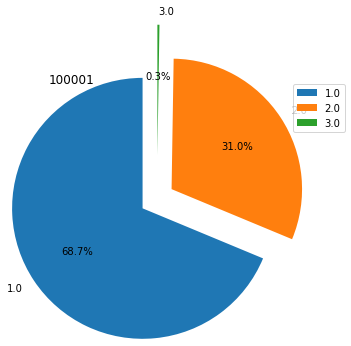

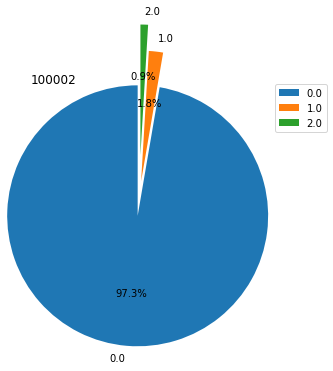

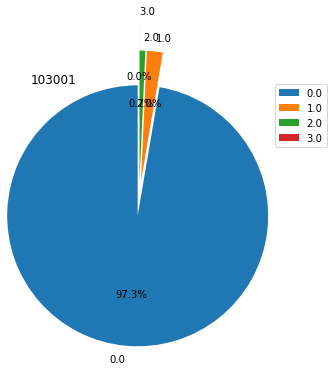

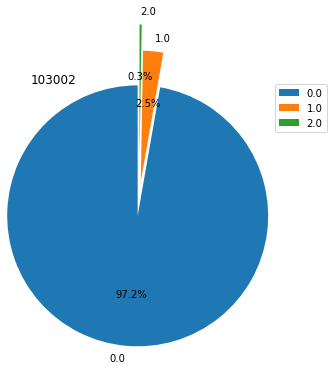

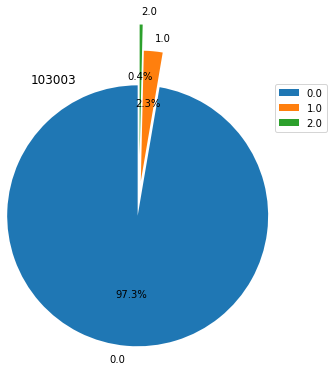

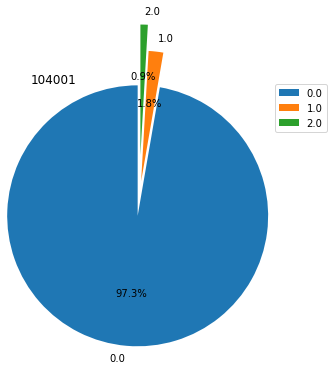

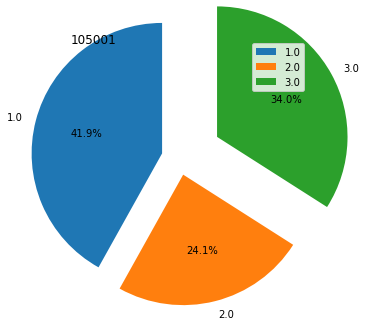

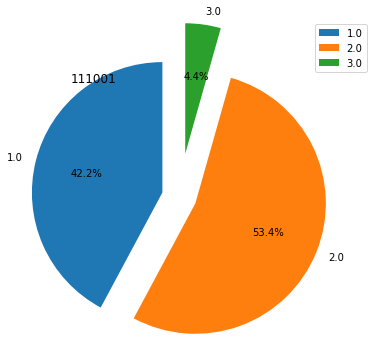

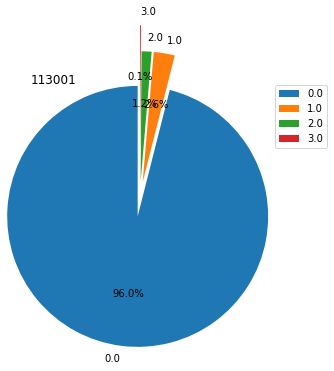

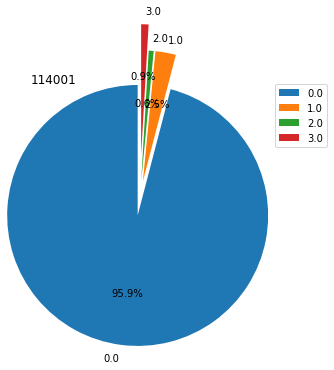

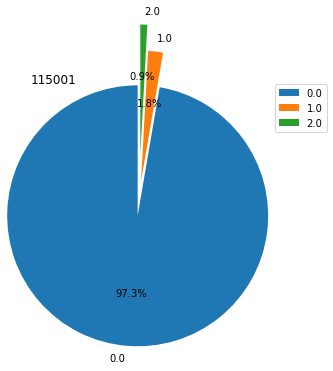

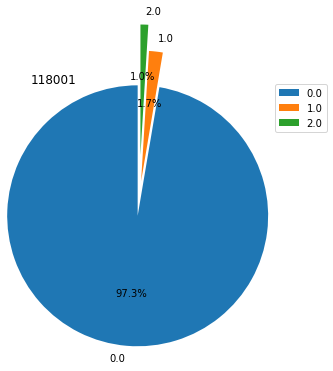

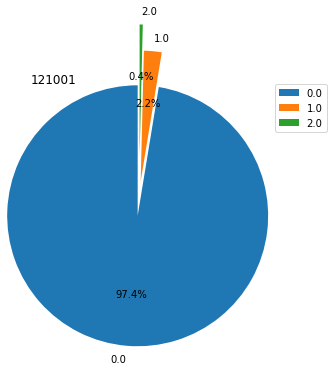

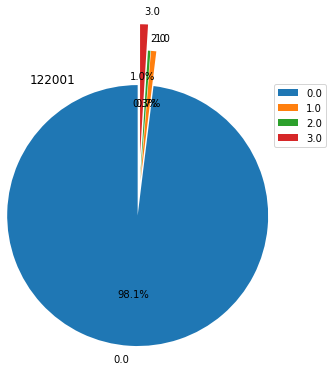

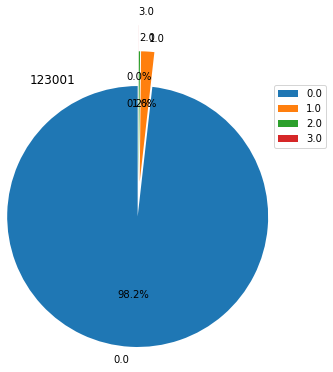

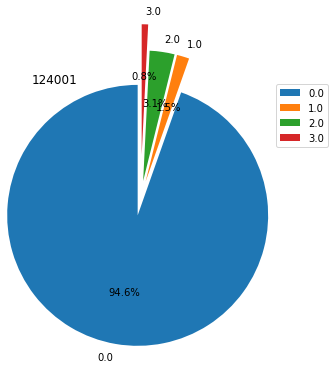

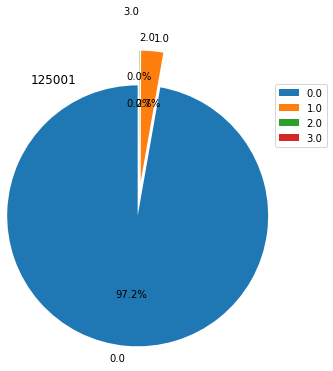

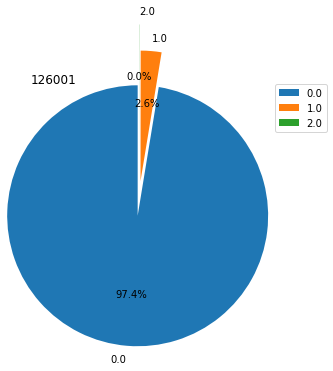

In [21]:
"""dataset['class_name'] = dataset['class'].apply(lambda x:
                                                     "Class 1: All significant waveforms" if int(x)==1 
                                                     else "Class 2: The noise level is increased" if int(x)==2
                                                     else "Class 3: The signal is unsuitable for any analysis. " if int(x)==3 
                                                     else "Class 0: The quality was not annotated ")
"""
for patient in dataannall.record.unique():
    pie_chart_data = dataset[dataset['record'] == patient].groupby('class')['sample'].sum()
    if pie_chart_data.shape[0] == 3:
        explode = (0.2,0.2,0.5)
    else:
        explode = (0.2,0.2,0.2,0.5)
    
    plt.figure()
    plt.pie(pie_chart_data.values, labels=pie_chart_data.index,  
           autopct='%1.1f%%',
           shadow=False, 
           startangle=90,
           explode=explode,
           radius=1.5
           )
    plt.title(patient, fontdict=None,loc='left')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

In [ ]:
# Do Pie Chart with plotly
#df = px.data.gapminder().query("year == 2007").query("continent == 'Europe'")
#df.loc[df['pop'] < 2.e6, 'country'] = 'Other countries' # Represent only large countries
#fig = px.pie(df, values='pop', names='country', title='Population of European continent')
#fig.show()

# Read source and create 2 lists
ecg_data : data
ecg_labels : labels quality class (1, 2 or 3; 0 means the quality was not annotated in this segment) 
Source : https://physionet.org/content/butqdb/1.0.0/

In [22]:
#For cut sample into n sample with cut_size
def ecgreshape(ecg_array,cut_size):
    ecg_size_multi = ceil(ecg_array.shape[0]/cut_size) # define number of subsamples
    ecg_result = np.zeros(ecg_size_multi*cut_size) # create an zero array of 5000 * subsamples
    ecg_result[:ecg_array.shape[0]] = ecg_array
    print(f"Array size {ecg_array.shape[0]} cut by {cut_size} done {ecg_size_multi}", end="\r")
    ecg_result = np.reshape(ecg_result, (ecg_size_multi,cut_size))
    return ecg_result

## Test with patient : 105001

In [43]:
# See annotation file for patient 105001
dataann = pd.read_csv("../aura-data/105001/105001_ANN.csv", names=header_list)
dataannclear = dataann[dataann["class"].notnull() & dataann["start"].notnull() & dataann["end"].notnull() ]
dataannclear['signal_length']=dataannclear['end'] - dataannclear['start'] 
dataannclear["sample"]=round(dataannclear["signal_length"]/sample_size)+1
dataannclear["indice"]=""
for i in range(len(dataannclear["sample"])):
    dataannclear.loc[i,"indice"]=dataannclear.loc[0:i,"sample"].values.sum()
display(dataannclear[0:10].head())


start1        end1  class1      start2        end2  class2    start3  \
0         1.0  47323379.0     3.0         1.0  47323871.0     3.0         1   
1  47323380.0  47388207.0     2.0  47323872.0  47329547.0     1.0  47323501   
2  47388208.0  47404719.0     1.0  47329548.0  47333899.0     2.0  47323540   
3  47404720.0  47449035.0     2.0  47333900.0  47370615.0     1.0  47326789   
4  47449036.0  47492819.0     1.0  47370616.0  47377747.0     2.0  47329716   

       end3  class3       start         end  class  signal_length  sample  \
0  47323500       3         1.0  47323500.0    3.0     47323499.0  9466.0   
1  47323539       1  47323501.0  47326788.0    2.0         3287.0     2.0   
2  47326788       2  47326789.0  47329547.0    1.0         2758.0     2.0   
3  47329715       1  47329548.0  47333904.0    2.0         4356.0     2.0   
4  47333904       2  47333905.0  47370615.0    1.0        36710.0     8.0   

  indice  
0   9466  
1   9468  
2   9470  
3   9472  
4   9480

We notice that the first line has a range of 47 millions that is quite huge
It seems to be an outliers, so we won't take it in account at first step

In [28]:
# Extract 5 first registers from 105001_ECG.dat, store data in ecg_data_105001 & label in ecg_labels_105001
header_list = ["start1", "end1", "class1","start2", "end2", "class2","start3", "end3", "class3","start", "end", "class"]
record_list = wfdb.get_record_list('butqdb')
record_list =['105001/105001_ECG']
ecg_data_105001=[np.zeros(sample_size)]
ecg_labels_105001=[0]
for rcd in record_list:
    if re.search(r'ECG$', rcd):
        record_name = f"../aura-data/{rcd}"
        print(record_name)
        record_csv = f"../aura-data/{rcd.replace('ECG','ANN')}.csv"
        dataann = pd.read_csv(record_csv, names=header_list)
        dataannclear = dataann[dataann["class"].notnull() & dataann["start"].notnull() & dataann["end"].notnull() ] 
        # We just take the rows of index from 1 to 5 in our dataset
        for i in tqdm(dataannclear[1:6].index):
            record = wfdb.rdrecord(record_name, sampfrom=int(dataannclear.start[i]), sampto=int(dataannclear.end[i]))
            ecg_data_105001 = np.concatenate((ecg_data_105001,ecgreshape(record.adc()[:,0],sample_size)), axis=0)
            ecg_size_multi = ceil(record.adc()[:,0].shape[0]/sample_size)
            ecg_labels_105001 = ecg_labels_105001 + [ int(dataannclear["class"][i]) for ii in range(ecg_size_multi)]
            #ecg_labels_test.append([int(dataannclear_nan_class["class"][i])])
ecg_data_105001 = np.delete(ecg_data_105001, (0), axis=0)
del ecg_labels_105001[0]
            

../aura-data/105001/105001_ECG


Array size 7131 cut by 5000 done 2


In [36]:
# Verify data & label array are ok
display(ecg_data_105001,ecg_labels_105001)

array([[-2.3653e+04, -2.3652e+04, -2.3650e+04, ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00],
       [-8.6330e+03, -8.6210e+03, -8.6080e+03, ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00],
       [-3.1110e+03, -3.1180e+03, -3.1130e+03, ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00],
       ...,
       [-1.4000e+01, -9.0000e+00, -1.1000e+01, ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00],
       [-5.8000e+01, -4.6000e+01, -3.4000e+01, ...,  5.0300e+02,
         4.9800e+02,  4.9400e+02],
       [ 5.0000e+02,  5.1300e+02,  5.2500e+02, ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00]])

[2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2]

## Test with patient : 111001

In [42]:
# See annotation file for patient 111001
dataann = pd.read_csv("../aura-data/111001/111001_ANN.csv", names=header_list)
dataannclear = dataann[dataann["class"].notnull() & dataann["start"].notnull() & dataann["end"].notnull()]
dataannclear['signal_length']=dataannclear['end'] - dataannclear['start'] 
dataannclear["sample"]=round(dataannclear["signal_length"]/sample_size)+1
dataannclear["indice"]=""
for i in range(len(dataannclear["sample"])):
    dataannclear.loc[i,"indice"]=dataannclear.loc[0:i,"sample"].values.sum()
display(dataannclear[0:10].head())


start1        end1  class1    start2      end2  class2  start3    end3  \
0        1.0   4315694.0     2.0       1.0  411254.0     2.0       1    7523   
1  4315695.0   4334794.0     1.0  411255.0  421291.0     1.0    7524   16977   
2  4334795.0   7908996.0     2.0  421292.0  433271.0     2.0   16978   18848   
3  7908997.0   7915643.0     1.0  433272.0  447315.0     1.0   18849  105566   
4  7915644.0  13719093.0     2.0  447316.0  451027.0     2.0  105567  108563   

   class3     start       end  class  signal_length  sample indice  
0       1       1.0  415143.0    2.0       415142.0    84.0     84  
1       2  415144.0  421291.0    1.0         6147.0     2.0     86  
2       1  421292.0  433515.0    2.0        12223.0     3.0     89  
3       2  433516.0  447315.0    1.0        13799.0     4.0     93  
4       1  447316.0  451027.0    2.0         3711.0     2.0     95

It seems to have a quite huge unbalance between classes, with a lot of values classed in class 2

In [44]:
# Extract 5 first registers from 105001_ECG.dat, store data in ecg_data_105001 & label in ecg_labels_105001
header_list = ["start1", "end1", "class1","start2", "end2", "class2","start3", "end3", "class3","start", "end", "class"]
record_list = wfdb.get_record_list('butqdb')
record_list =['111001/111001_ECG']
ecg_data_111001=[np.zeros(sample_size)]
ecg_labels_111001=[0]
for rcd in record_list:
    if re.search(r'ECG$', rcd):
        record_name = f"../aura-data/{rcd}"
        print(record_name)
        record_csv = f"../aura-data/{rcd.replace('ECG','ANN')}.csv"
        dataann = pd.read_csv(record_csv, names=header_list)
        dataannclear = dataann[dataann["class"].notnull() & dataann["start"].notnull() & dataann["end"].notnull() ] 
        # We just take the rows of index from 1 to 5 in our dataset
        for i in tqdm(dataannclear[1:6].index):
            record = wfdb.rdrecord(record_name, sampfrom=int(dataannclear.start[i]), sampto=int(dataannclear.end[i]))
            ecg_data_111001 = np.concatenate((ecg_data_111001,ecgreshape(record.adc()[:,0],sample_size)), axis=0)
            ecg_size_multi = ceil(record.adc()[:,0].shape[0]/sample_size)
            ecg_labels_111001 = ecg_labels_111001 + [ int(dataannclear["class"][i]) for ii in range(ecg_size_multi)]
            #ecg_labels_test.append([int(dataannclear_nan_class["class"][i])])
ecg_data_111001 = np.delete(ecg_data_111001, (0), axis=0)
del ecg_labels_111001[0]
            

../aura-data/111001/111001_ECG


Array size 5593 cut by 5000 done 2


In [46]:
# Verify data & label array are ok
display(ecg_data_111001,ecg_labels_111001)

array([[ 119.,  125.,  138., ..., -467., -469., -477.],
       [-485., -482., -478., ...,    0.,    0.,    0.],
       [ 148.,  147.,  160., ..., -281., -293., -332.],
       ...,
       [ 124.,  134.,  134., ...,    0.,    0.,    0.],
       [ 647.,  635.,  639., ..., -244., -232., -234.],
       [-243., -239., -238., ...,    0.,    0.,    0.]])

[1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1]

In [473]:
# Split data in different array for each class
arr_class_1 = [np.zeros(sample_size)]
arr_class_2 = [np.zeros(sample_size)]
# Filter the 200 first values
for i, j in enumerate(ecg_data_111001[:200]):
    if j == 1:
        arr_class_1 = np.append(arr_class_1,[ecg_data_2[i]],axis=0)
    if j == 2:
        arr_class_2 = np.append(arr_class_2,[ecg_data_2[i]],axis=0)
arr_class_1 = np.delete(arr_class_1, (0), axis=0)
arr_class_2 = np.delete(arr_class_2, (0), axis=0)

In [479]:
arr_class_1 = np.delete(arr_class_1, (0), axis=0)
arr_class_2 = np.delete(arr_class_2, (0), axis=0)

# Scaleogram

Default wavelet function used to compute the transform: morl ( Morlet wavelet )
Default wavelet function used to compute the transform: morl ( Morlet wavelet )
Default wavelet function used to compute the transform: morl ( Morlet wavelet )
Default wavelet function used to compute the transform: morl ( Morlet wavelet )
Default wavelet function used to compute the transform: morl ( Morlet wavelet )


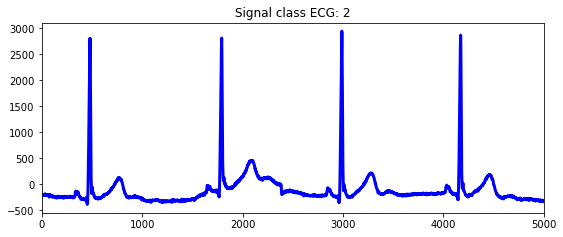

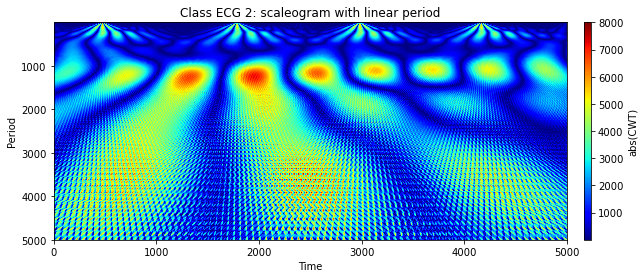

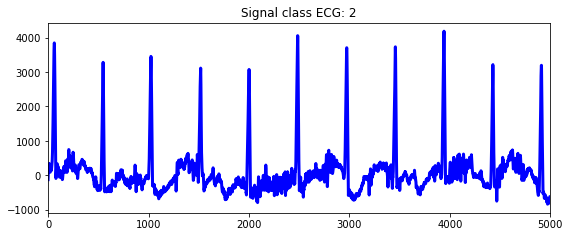

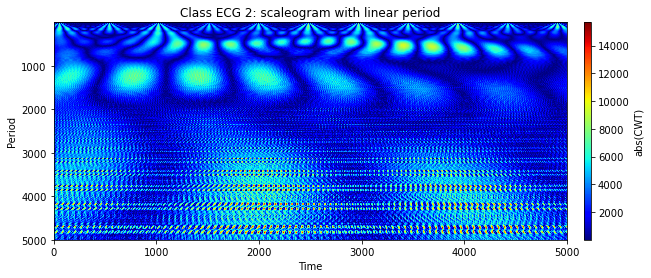

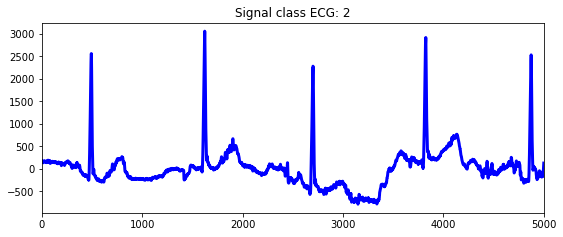

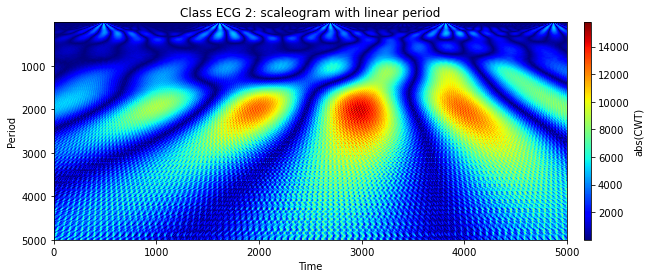

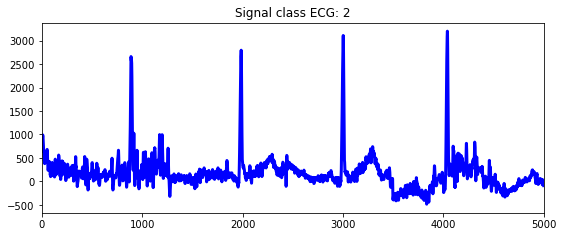

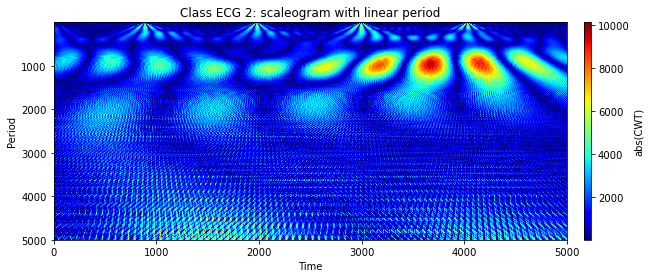

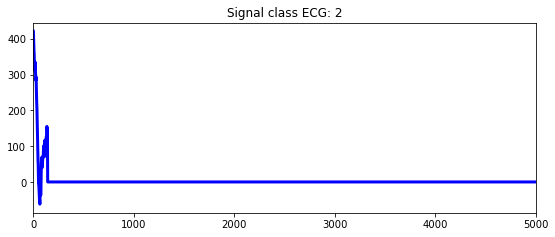

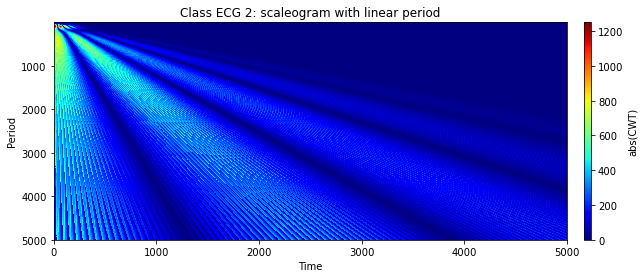

In [279]:
# choose default wavelet function 
scg.set_default_wavelet('morl')

# Choice 5 random values in the array indice range
alist = np.random.choice(range(len(ecg_data_111001)),5)

# Display signal & his scaleogram for each index
for i in alist:
    nn = i
    signal_length = 5000
    # range of scales to perform the transform
    scales = scg.periods2scales( np.arange(1, signal_length+1) )
    x_values_wvt_arr = range(0,len(ecg_data_111001[nn]),1)

    # plot the signal 
    fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
    ax1.plot(x_values_wvt_arr, ecg_data_111001[nn], linewidth=3, color='blue')
    ax1.set_xlim(0, signal_length)
    ax1.set_title(f"Signal class ECG: {ecg_labels_111001[nn]}")

    # the scaleogram
    scg.cws(ecg_data_111001[nn][:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
            title=f"Class ECG {ecg_labels_111001[nn]}: scaleogram with linear period"); 

    print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
          pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")
    

# Classification

In [483]:
arr_class_1[:15].shape, arr_class_2[:184].shape

((15, 5000), (184, 5000))

In [492]:
arr_class_1 = arr_class_1[:15][:4900]
arr_class_2 = arr_class_2[:184][:4900]

In [493]:
arr_class_1_split_256 = [np.array_split(arr_class_1, 70) for ii in range(15)]
arr_class_2_split_256 = [np.array_split(arr_class_2, 70) for ii in range(184)]

In [494]:
arr_class_1_flatten = [item for sublist in arr_class_1_split_256 for item in sublist]
arr_class_2_flatten = [item for sublist in arr_class_2_split_256 for item in sublist]

In [495]:
reduce_size = 500
full_1000 = (arr_class_1_flatten[0:reduce_size] + arr_class_2_flatten[0:reduce_size])
             

In [2]:
full_1000[0]

NameError: name 'full_1000' is not defined

In [1]:
# create the data set
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


fs = len(full_1000[0])
sgn_length = 2000   #65536   Pay atention with ram memory! 
size_dataset = len(full_1000)
scales = range(1, fs)
waveletname = 'morl'
 
X_full = np.ndarray(shape=(size_dataset, fs-1, fs-1, 3))
                 
for i in range(0, size_dataset):
    if i % 500 == 0:
        print (i, 'done!')
    for j in range(0, 3):
        signal = full_1000[i]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        X_full[i, :, :, j] = coeff[:,:fs-1]

KeyboardInterrupt: 

In [340]:
X_full.shape

(140, 69, 69, 3)

In [341]:
list_ecg_labels_class_1 = ['1']*70 
list_ecg_labels_class_2 = ['2']*70 
list_ecg_labels = (list_ecg_labels_class_1 + list_ecg_labels_class_2)

le = preprocessing.LabelEncoder()
ecg_labels_encoded = le.fit_transform(list_ecg_labels)
X_train, X_test, y_train, y_test = train_test_split(X_full, ecg_labels_encoded, test_size=0.25, random_state=42)


In [329]:
import sys
from tensorflow import keras

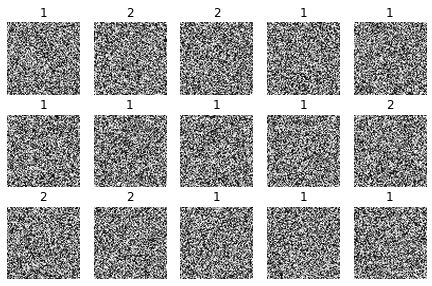

In [342]:
#Inspecting DATA
n_rows = 3
n_cols = 5
class_names = ['1', '2']
plt.figure(figsize=(n_cols*1.5, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow((X_train[index]*255).astype(np.uint8), cmap="binary", interpolation="spline36")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

In [346]:
# Defining basic NN
num_filter, num_classes = 3, 2
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[fs-1, fs-1, num_filter]),
    keras.layers.Dense(300, activation="relu"),                 
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(num_classes, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])

In [347]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 14283)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 300)               4285200   
_________________________________________________________________
dense_13 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 202       
Total params: 4,315,502
Trainable params: 4,315,502
Non-trainable params: 0
_________________________________________________________________


In [348]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
4/4 [==============================] - 0s 54ms/step - loss: 1017611274365698048.0000 - accuracy: 0.4952 - val_loss: 87755320782916124477333962752.0000 - val_accuracy: 0.5143
Epoch 2/10
4/4 [==============================] - 0s 15ms/step - loss: nan - accuracy: 0.5238 - val_loss: nan - val_accuracy: 0.5143
Epoch 3/10
4/4 [==============================] - 0s 17ms/step - loss: nan - accuracy: 0.4952 - val_loss: nan - val_accuracy: 0.5143
Epoch 4/10
4/4 [==============================] - 0s 13ms/step - loss: nan - accuracy: 0.4952 - val_loss: nan - val_accuracy: 0.5143
Epoch 5/10
4/4 [==============================] - 0s 13ms/step - loss: nan - accuracy: 0.4952 - val_loss: nan - val_accuracy: 0.5143
Epoch 6/10
4/4 [==============================] - 0s 13ms/step - loss: nan - accuracy: 0.4952 - val_loss: nan - val_accuracy: 0.5143
Epoch 7/10
4/4 [==============================] - 0s 15ms/step - loss: nan - accuracy: 0.4952 - val_loss: nan - val_accuracy: 0.5143
Epoch 8/10
4/4 [=